This notebook preprocesses the true data and gives descriptive statistics

In [1]:
# install packages

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load true data
with open('AGMT_data.pkl', 'rb') as f:
    raw_data = pickle.load(f)

# Key Features

The DataFrame "raw_data" is now containing the whole information of the clinical trial and we extract some key features.

In [3]:
# What is the time span of the study?
raw_data["cycle_date"].describe()

count                             1453
mean     2016-04-13 23:35:13.420509184
min                2012-01-16 00:00:00
25%                2014-05-26 00:00:00
50%                2016-08-29 00:00:00
75%                2018-02-12 00:00:00
max                2020-08-24 00:00:00
Name: cycle_date, dtype: object

The earlierst data comes from 16 January 2012, while the latest is from 24 August 2020.

In [4]:
# How many participants were involved?
raw_data["patient_id"].drop_duplicates() # don´t count patients with multiple observations several times

2123_1     2123
3163_2     3163
3203_1     3203
3563_1     3563
3221_1     3221
           ... 
4585_1     4585
5625_9     5625
5644_4     5644
3449_58    3449
3450_4     3450
Name: patient_id, Length: 269, dtype: int64

In total, $269$ patients participated in the study.

In [5]:
# How many observations were taken?
len(raw_data)

1453

All participants together contributed $1453$ observations.

In [6]:
# How many covariates are measured?
all_keys = raw_data.keys()
print(len(all_keys))
print(all_keys[0:4])

62
Index(['patient_id', 'eq5d_data', 'cycle_nr', 'cycle_date'], dtype='object')


Each observation has up to 62 entries of which the first four are administrative. Thus, the number of covariates equals $62-4=58$.

In [7]:
# Is the summary EQ-5D score informative?
raw_data["eq5d"].describe()

count    1453.000000
mean        1.154852
std         0.361888
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: eq5d, dtype: float64

The summary EQ-5D score shows little variation.

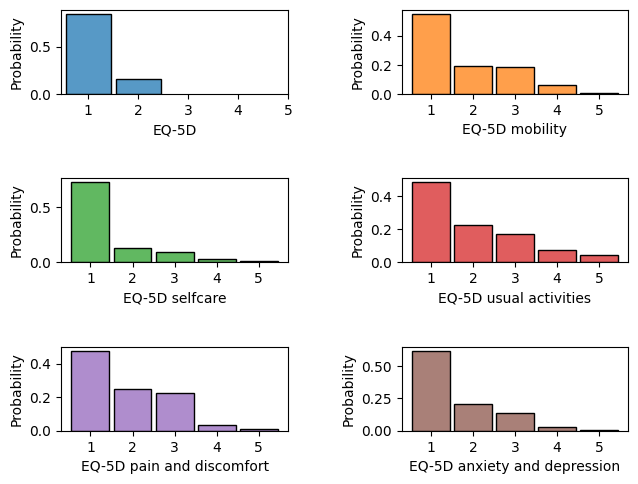

In [8]:
# Plot histograms for the five sub-categories of the EQ-5D data and haemoglobin.


keys = ["eq5d","eq5d_mobility", "eq5d_selfcare", "eq5d_usual_activities", "eq5d_pain_discomfort", "eq5d_anxiety_depression", "eq5d_health_today", "hb"] # covariates of interest
full_data = raw_data[raw_data[keys].notna()] # clear for all NaN

titles = ["EQ-5D", "EQ-5D mobility", "EQ-5D selfcare", "EQ-5D usual activities", "EQ-5D pain and discomfort", "EQ-5D anxiety and depression", "EQ-5D health today", "haemoglobin concentration $[g/dl]$"]
colours = sns.color_palette(n_colors = 10)

# plot histograms for EQ-5D sub-categories
fig, axs = plt.subplots(3,2)
fig.tight_layout()
fig.subplots_adjust(wspace = 0.5, hspace = 1)

for i in range(3):
    for j in range(2):
        k = 2*i+j
        sns.histplot(full_data, x = keys[k], ax = axs[i,j], label = keys[k], discrete = True, stat = "probability", color= colours[k], shrink = 0.9)
        axs[i,j].set_xlabel(titles[k])
        axs[i,j].set_xticks([1,2,3,4,5])

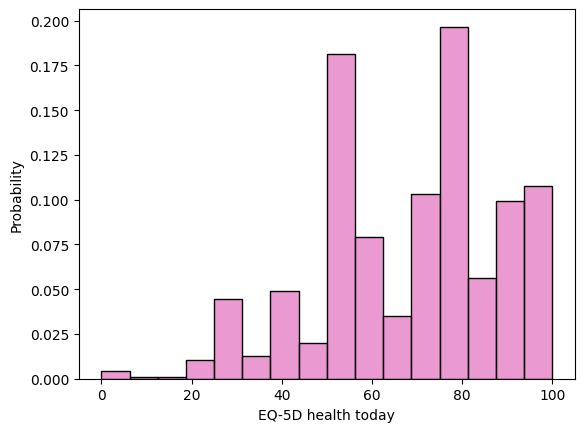

In [9]:
# plot histogram for health today
sns.histplot(raw_data, x = "eq5d_health_today", stat = "probability", color = colours[6])
plt.xlabel(titles[6])
plt.show()

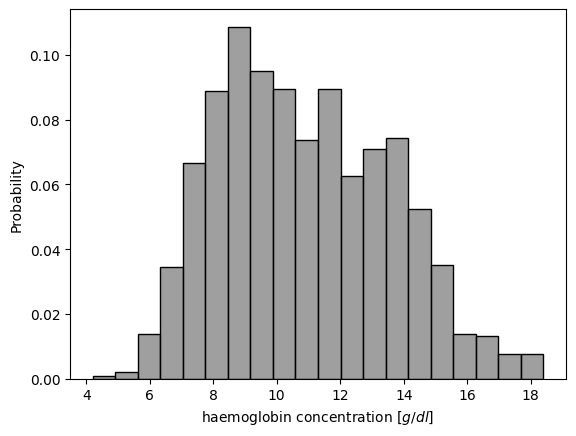

In [10]:
# plot histogram for h
# fix, ax = plt.subplots(1,1)
sns.histplot(full_data, x = "hb", stat = "probability",color = colours[7])
plt.xlabel(titles[7])
plt.show()

In [11]:
# describe haemoglobin values
full_data["hb"].describe()

count    1453.000000
mean       10.902409
std         2.675918
min         4.200000
25%         8.800000
50%        10.600000
75%        13.000000
max        18.400000
Name: hb, dtype: float64

# Pre-processing

Now that eq5d_usual_activities determines the state space, we discard any observation that has invalid entries.

In [12]:
# Which columns of interest contain NaN?
keys = ["patient_id", "cycle_date", "eq5d_usual_activities", "hb"]

raw_data[keys].notna().all()

patient_id                True
cycle_date                True
eq5d_usual_activities    False
hb                        True
dtype: bool

Thus it suffices to only check eq5d_usual_activities for NaN

In [13]:
# exclude NaN
clear_data = raw_data[raw_data["eq5d_usual_activities"].notna()][keys]

In [15]:
# How many observations are left?
l_1 = len(clear_data)
print(l_1)

1421


In [16]:
# How many patients does this involve?
clear_data["patient_id"].drop_duplicates() # don´t count patients with multiple observations several times

2123_1     2123
3163_2     3163
3203_1     3203
3563_1     3563
3221_1     3221
           ... 
4585_1     4585
5625_9     5625
5644_4     5644
3449_58    3449
3450_4     3450
Name: patient_id, Length: 263, dtype: int64

We keep 263 patients and a total of 1421 observations.

In order view the data as observation frames, we need to ensure that a patient was observed at least two times and measure the time difference in days as well as the respective next state.

In [18]:
# select rows that have several observations
val_obs = np.repeat(False,l_1)                  # to check for sufficiently many observations
obs_times = np.repeat(0,l_1)                    # dummy for the observation times
next_state = np.repeat(0,l_1)                   # dummy for next states

for i in range(l_1-1):
    # check if this is not the last check-up and obtain observation time
    if (clear_data["patient_id"].iloc[i] == clear_data["patient_id"].iloc[i+1]):                            # if the patient id of the current and next observation coincide, this can be transformed into a valid observation
        obs_times[i] = (clear_data["cycle_date"].iloc[i+1]-clear_data["cycle_date"].iloc[i]).days           # get the elapsed time between the two observation in days
        next_state[i] = clear_data["eq5d_usual_activities"].iloc[i+1]                                       # get the state of the following observation as next state
        val_obs[i] = True

Add observation time and next state to the DataFrame and exlude patients with single observations.

In [19]:
# add observation time and next state
clear_data = clear_data.assign(observation_time = obs_times, final_state = next_state)

# exclude single observations
mod_data = clear_data[val_obs]

Reshape the DataFrame for estimation procedure

In [20]:
# relable the index
mod_data.index = np.arange(0,len(mod_data.index))

# define eq5d_usual_activities as initial value and set to integer values
mod_data = mod_data.assign(initial_state = mod_data["eq5d_usual_activities"].astype(int))

# discard unneccessary columns
keys = ["patient_id","initial_state", "final_state", "observation_time", "hb"]

# exlude outliers for observation times that are too long
T_crit = mod_data["observation_time"].quantile(0.99)        # critical value which determine if an observation time is an outlier
mod_data = mod_data[mod_data["observation_time"] <= T_crit]

data = mod_data[keys]

In [21]:
# What is critical value for outliers?
print(T_crit)

303.03000000000134


The $99\%$-quantile for observation times is around 304.

In [22]:
# How many pairs of subsequent check-ups do we have?
L = len(data)
print(L)

1146


We end up with $1146$ observation frames.

In [23]:
# How many patients does this involve?
data["patient_id"].drop_duplicates() # don´t count patients with multiple observations several times

0       3256
1         11
12        17
22        42
45        74
        ... 
1145    3479
1148    3480
1151    3569
1154    4585
1157    5644
Name: patient_id, Length: 190, dtype: int64

190 patient contribute to the observation frames.

Save processed data as new DataFram

In [24]:
# save as pkl file
with open(rf"data.pkl", "wb") as handle:
    pickle.dump(data, handle)

# Descriptive Statistics

## Approximation of the histograms

To determine some of the hyperparameters. we try to replicate the previous histograms for the eq5d_usual_activities score and the haemoglobin value.

In [25]:
# fixed settings
n_samples = 1000

# set seed
RNG = np.random.default_rng(2024)


Model the eq5d_usual_activities as truncated geometric distribution with rate $p=0.6$.

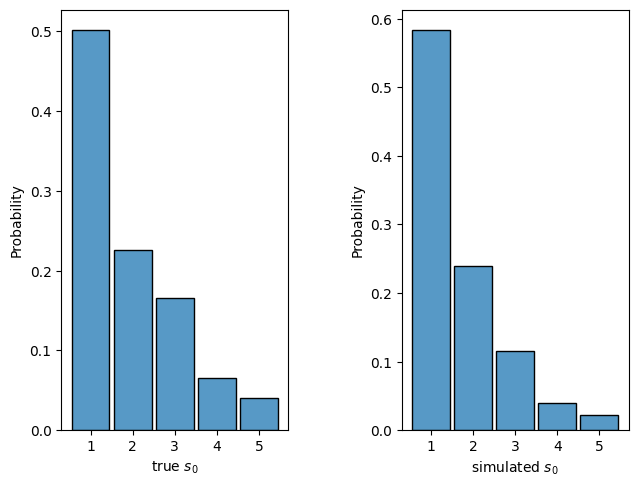

In [26]:
# sample from geometric distribution
p = 0.6

state_samples = RNG.geometric(p = p,size = n_samples)

# truncate samples
for i in range(1000):
    if state_samples[i] >= 5:
        state_samples[i] = 5

fig, axs = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(wspace = 0.5)
sns.histplot(data, x = "initial_state", ax = axs[0], discrete = True, stat = "probability", shrink = 0.9)
axs[0].set_xlabel("true $s_0$")
axs[0].set_xticks([1,2,3,4,5])
sns.histplot(state_samples, ax = axs[1], discrete = True, stat = "probability", shrink = 0.9)
axs[1].set_xlabel("simulated $s_0$")
axs[1].set_xticks([1,2,3,4,5])
plt.show()

Model the haemoglobin values as a mixture of two normal distributions with paramters $(11.5,2)$ and $(13.5,2)$.

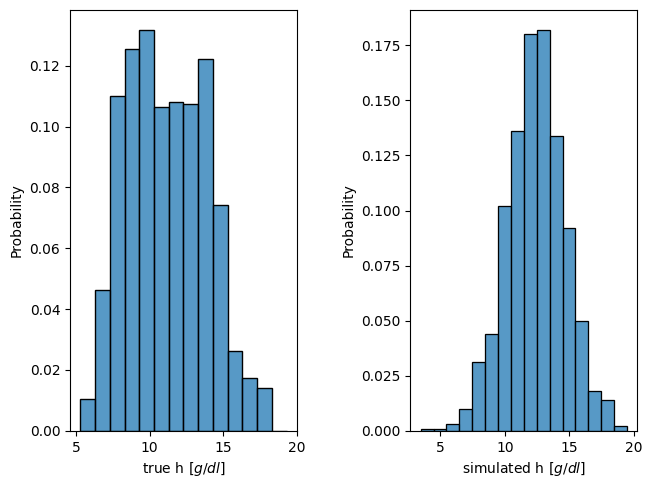

In [27]:
# sample from mixed normal distribution
mu_f = 11.5
mu_m = 13.5
sigma = 2.0

hb_samples = np.zeros(n_samples)

# sample from mixed distribution
for i in range(1000):
    z = np.random.binomial(n = 1, p = 0.5, size = 1)
    if (z == 0):
        hb_samples[i] = RNG.normal(loc = mu_f, scale = sigma)
    else:
        hb_samples[i] = RNG.normal(loc = mu_m, scale = sigma)

fig, axs = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(wspace = 0.5)
sns.histplot(data, x = "hb", ax = axs[0], discrete = True, stat = "probability")
axs[0].set_xlabel("true h $[g/dl]$")
sns.histplot(hb_samples, ax = axs[1], discrete = True, stat = "probability")
axs[1].set_xlabel("simulated h $[g/dl]$")
plt.show()


Histogram of the observation times

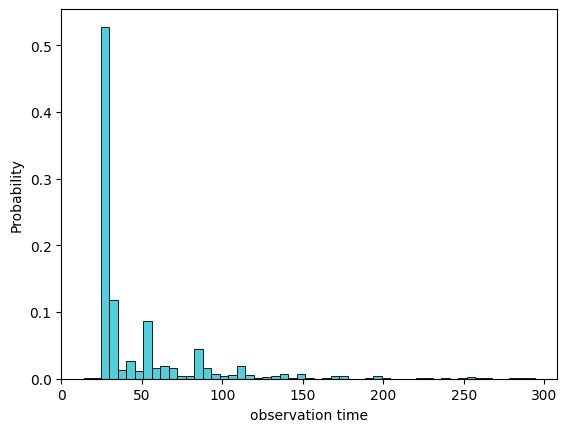

In [29]:
sns.histplot(data, x = "observation_time", color = colours[9], stat = "probability")
plt.xlabel("observation time")
plt.show()

In [30]:
# What is the mean observation time?
data["observation_time"].describe()

count    1146.000000
mean       48.885689
std        39.622851
min        14.000000
25%        28.000000
50%        29.000000
75%        56.000000
max       294.000000
Name: observation_time, dtype: float64

The mean observation time is around $49$ days.

In [31]:
# What is the off-set for simulating observation times?
print(data["observation_time"].quantile(0.01))

26.0


The off-set for the observation times is $c_{obs}=26$.